# Classification & Regression

### Setting up the Notebook

In [3]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# This will automatically reload src/dtree.py every time you make changes and save the file
%load_ext autoreload
%autoreload 2

In [95]:
%matplotlib notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


from src.dtree import MyDecisionTree
from src.utils import plot_validation_results, plot_scores

## 1 Implementing a Decision Tree Classifier (30 Points)

In this section, you will implement your own Decision Tree classifier. This will test but also deepen your understanding of the inner workings of Decision Trees. The keep the complexity low, the Decision tree will be simplified compared to the general model you've seen in the lecture:

* Only numerical features are supported
* Only binary splits are supported

(incidentally, this is in line with scitkit-learn's [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) implementation)

All the implementation is done in file `src/dtree.py` This files contains the definition of all required methods with some first code snippets, as well as additional documentation describing the expected input and output of each method.

**In the following substasks, you will complete the methods where indicated by the comments within each method.** 

#### Create Some Toy Data for Testing & Debugging

In [3]:
# Training data (8 samples with 2 features)
X_train = np.array([ [1.0, 5.0], [2.0, 7.0], [3.0, 4.0], [4.0, 3.0], [5.0, 1.0], [6.0, 8.0], [7.0, 6.0], [8.0, 2.0] ] )
y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1])

# Test data (2 samples)
X_test = np.array([ [2.0, 2.0], [3.0, 3.0] ])
y_test = np.array([0, 1])

### 1.1 Scoring Nodes and Splits (4 Points)

For quick testing and debugging, let's define 3 example sets of labels. Note that `y1` and `y2` contain only 2 labels (binary classification), while `y3` contains 3 labels. Your implementation should not depend on the number of labels.

In [4]:
y1 = np.array([1, 1, 1, 1, 1, 1, 1, 1])
y2 = np.array([0, 0, 0, 0, 1, 1, 1, 1])
y3 = np.array([2, 0, 1, 1, 2, 2, 0, 2])

#### 1.1 a) Calculating the Gini Score for a Node (2 Points)

Recall from the lecture, that the Gini score of a node $t$ is defined as:

$$Gini(t) = 1 - \sum_{c\in C} P(c|t)^2$$

where $C$ is the set of classes, and $P(c|t)$ is the relative frequency of class $c$ in node $t$.

**Implement this formula in method `calc_gini_score_node()`!** (Hint: Have a look at [`np.unique`](https://numpy.org/doc/stable/reference/generated/numpy.unique.html) and basic `numpy` methods such as [`np.sum`](https://numpy.org/doc/stable/reference/generated/numpy.sum.html) and [`np.square`](https://numpy.org/doc/stable/reference/generated/numpy.square.html) to make you life easier. There should be no need for any loops, but it's up to you how to implement the method.)

You can use the example calls below to test your implementation of the method.

In [5]:
dt = MyDecisionTree()

gini_score = dt.calc_gini_score_node(y1)  # Expected score: 0.0
gini_score = dt.calc_gini_score_node(y2)  # Expected score: 0.5
gini_score = dt.calc_gini_score_node(y3)  # Expected score: 0.625

print(gini_score)

0.625


#### 1.1 b) Calculating the Gini Score for a Split (2 Points)

In the lecture, we defined the impurity of a split as the average of the impurities of the child nodes, weighted by there size (in terms of the number of samples in each child node). Since we only consider binary splits (2 child nodes) and consider only the Gini score to measure impurity, the Gini score of a split simplifies to:

$$Gini(t_{left}, t_{right}) = \frac{n_{left}}{n}Gini(t_{left}) + \frac{n_{right}}{n}Gini(t_{right})$$

where $n_{left}$ ($n_{right}$) is the number of samples in the left (right) child node; and $n = n_{left} + n_{right}$

**Implement this formula in method `calc_gini_score_split`!** You obviously can and should use of the existing method `calc_gini_score_node()`.

You can use the example calls below to test your implementation of the method.

In [6]:
dt = MyDecisionTree()

gini_score = dt.calc_gini_score_split(y1, y1)  # Expected score: 0.0
gini_score = dt.calc_gini_score_split(y1, y2)  # Expected score: 0.25
gini_score = dt.calc_gini_score_split(y1, y3)  # Expected score: 0.3125

print(gini_score)

0.3125


### 1.2 Finding the Best Split (14 Points)

#### 1.2 a) Calculating All Possible Thresholds (3 Points)

We have seen in the lecture, that we can split numerical features using thresholds that separate the feature values into all values less or equal to a threshold and larger then the threshold. 

**Implement the method `calc_thresholds`!** You obviously can and should use of the existing method `calc_gini_score_node()`. (Hint: Again, [`np.unique`](https://numpy.org/doc/stable/reference/generated/numpy.unique.html) might make life easier)

In [7]:
dt = MyDecisionTree()

thresholds = dt.calc_thresholds(X_train[:,0])  # Expected output: [1.5 2.5 3.5 4.5 5.5 6.5 7.5]
thresholds = dt.calc_thresholds(X_train[:,1])  # Expected output: [1.5 2.5 3.5 4.5 5.5 6.5 7.5]

print(thresholds)

{1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5}


#### 1.2 b) Creating a Split (3 Points)

**Implement the method `create_split()`** that splits a list of numerical values w.r.t. a given threshold. Note that a split is represented by the indices of the values in the list and not the values itself. This saves memory and simplifies the implementation. (Hint: Have a look at [`np.where`](https://numpy.org/doc/stable/reference/generated/numpy.where.html))

In [8]:
dt = MyDecisionTree()

split = dt.create_split(X_train[:,0], 4.5)  # Expected output: [0 1 2 3] [4 5 6 7]
split = dt.create_split(X_train[:,1], 4.5)  # Expected output: [2 3 4 7] [0 1 5 6]

print(split[0], split[1])

[2, 3, 4, 7] [0, 1, 5, 6]


#### 1.2 c)  Find the Best Split for a Single Feature (4 Points)

Now that we know how to split as well as to score a split, we can find the best split for a feature.

**Implement the method `calc_best_split_feature`!** With the methods you have already implemented and the given code parts in the method, this should be very straightforward.

In [9]:
dt = MyDecisionTree()

for feature in range(X_train.shape[1]):
    score, threshold, split = dt.calc_best_split_feature(X_train[:,feature], y_train)

    print('[Feature {}] Gini: {:.3f}, threshold: {}, split: {} {}'.format(feature, score, threshold, split[0], split[1]))

[Feature 0] Gini: 0.000, threshold: 4.5, split: [0, 1, 2, 3] [4, 5, 6, 7]
[Feature 1] Gini: 0.333, threshold: 2.5, split: [4, 7] [0, 1, 2, 3, 5, 6]


Applied on the toy dataset, the output should look like this:
    
```
[Feature 0] Gini: 0.000, threshold: 4.5, split: [0 1 2 3] [0 1 2 3 5 6]
[Feature 1] Gini: 0.333, threshold: 2.5, split: [4 7] [0 1 2 3 5 6]
```

#### 1.2 d) Find the Best Split across All Features (4 Points)

With the method that gives us the best split for a single feature in place, we now only need the method that gives us the best split across all features available in a dataset.

**Implement the method `calc_best_split`!** It will look very similar to method `calc_best_split_feature()`, arguably even a bit simpler. (Hint: The code cell above for testing `calc_best_split_feature()` is basically giving it away)

In [10]:
dt = MyDecisionTree()

score, threshold, feature, split = dt.calc_best_split(X_train, y_train)

print('[Feature {}] Gini: {:.3f}, threshold: {}, split: {} {}'.format(feature, score, threshold, split[0], split[1]))

[Feature 0] Gini: 0.000, threshold: 4.5, split: [0, 1, 2, 3] [4, 5, 6, 7]


Applied on the toy dataset, the output should look like this:

```
[Feature 0] Gini: 0.000, threshold: 4.5, split: [0 1 2 3] [4 5 6 7]
```

This shouldn't be surprising as we already saw above, where we calculated the best splits for each feature, that Feature 0 results in the best split (in a perfect split, in fact).

### 1.3 Training the Decision Tree (4 Points)

With all the methods for scoring and splitting nodes in place, we can now train our Decision Tree. Have a good look at methods `fit()` and `_fit()` and get a good understanding! It basically contains all the code required for recursively splitting nodes. So you don't have to worry about that.

The only things missing from the `_fit()` method are the conditions of when to stop the recursion. Some conditions can be checked before calculating the best split, some afterwards (cf. lecture slides, including the ones to avoid overfitting).

**Implement all 4 conditions to stop the recursion in method `_fit()`, and try to do them as early as possible!** Each condition will be a simple `IF` statement that will `return` if true. (Hint: The 2 parameters `max_depth` and `min_samples_split` are adopted from scikit-learn's [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html); only exception: `min_samples_split` is only interpreted as *int*.)

In [11]:
dt = MyDecisionTree(max_depth=1, min_samples_split=10).fit(X_train, y_train)
#dt = MyDecisionTree(max_depth=1, min_samples_split=6).fit(X_train, y_train)

print(dt)

 Leaf, gini: 0.500, #samples: 8



For `(max_depth=1, min_samples_split=10)` the output should look like this:
```
 Leaf, gini: 0.500, #samples: 8
```

For `(max_depth=1, min_samples_split=6)` the output should look like this:
```
 X[0] <= 4.500, gini: 0.500, #samples: 8
--- Leaf, gini: 0.000, #samples: 4
--- Leaf, gini: 0.000, #samples: 4
```

### 1.4 Predicting Labels (3 Points

Now that you can train your Decision Tree classifier, all that's left is to predict the class labels for unseen data samples. We saw in the lecture that making prediction using Decision Trees translates to going down the tree based on the decisions encoded in each node until reaching a leaf node. This leaf node contains 1 or more class labels and the final prediction will be the most frequent class label of that leaf node.

Have a look at methods `predict()` and `predict_sample()`; notice the `predict()` does nothing else than to call `predict_sample()` for each sample in X.

**Implement the method `predict_sample()`!** The method already implements the recursive part of "going down" the tree to find the correct leaf node. You only need to implement the return of the final prediction once the correct leaf node is found. (Hint: Again, [`np.unique`](https://numpy.org/doc/stable/reference/generated/numpy.unique.html) might make life easier, and you might want to have a look at [`np.argmax`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) as well.)

In [12]:
y_pred = dt.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')

print('The f1 score of your Decision Tree implementation on the toy dataset is {:.3f}'.format(f1))

The f1 score of your Decision Tree implementation on the toy dataset is 0.333


If you used `dt.fit(X_train, y_train, max_depth=1, min_samples_split=10)` on the toy dataset, the resulting f1 score should be **0.333**.

### Testing your Implementation on the IRIS Dataset

**You are done with Task 1!** This part is only for you to test your implementation on a real-world dataset (IRIS) since the toy dataset might not reveal all bugs in your code. You can also directly compare the result your Decision Tree implementation with the results from scikit-learn's [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html); they should be *more or less* the same.

#### Create Training and Test Data 

In [13]:
df = pd.read_csv('data/iris.csv')                  # Load file into dataframe
df['species'] = pd.factorize(df['species'])[0]     # Convert string labels into numeric labels (0, 1 and 2)

# Convert dataframes to numpy arrays
X = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].to_numpy()
y = df[['species']].to_numpy().squeeze()

# Split dataset into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("Size of training set: {}".format(len(X_train)))
print("Size of test: {}".format(len(X_test)))

Size of training set: 120
Size of test: 30


#### Train & Evaluate Your Decision Tree Implementation

In [14]:
dt = MyDecisionTree(max_depth=2)
dt.fit(X_train, y_train)

print(dt)

 X[3] <= 0.800, gini: 0.665, #samples: 120
--- Leaf, gini: 0.000, #samples: 39
--- X[3] <= 1.750, gini: 0.496, #samples: 81
------ Leaf, gini: 0.180, #samples: 40
------ Leaf, gini: 0.048, #samples: 41



For dt.fit(X_train, y_train, max_depth=2) the Decision Tree **might** look like this

```
 X[3] <= 0.800, gini: 0.665, #samples: 120
--- Leaf, gini: 0.000, #samples: 39
--- X[3] <= 1.750, gini: 0.496, #samples: 81
------ Leaf, gini: 0.180, #samples: 40
------ Leaf, gini: 0.048, #samples: 41
```

Depending on your exact implementation, your output might slightly vary as there are at least 2 splits of the root note with the same **Ginig score of 0.665**. However, the Gini score of the root node should be indeed 0.665!

Predicting the labels of the test data:

In [15]:
y_pred = dt.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')

print('The f1 score of your Decision Tree implementation on the IRIS dataset is {:.3f}'.format(f1))

The f1 score of your Decision Tree implementation on the IRIS dataset is 0.957


You should see a f1 score of **0.957** with `dt.fit(X_train, y_train, max_depth=2)`, even with the alternative root note split. However, no need to worry in case your f1 score is slightly different.

#### Compare with scikit-learn Implementation

Let's train a Decision Tree using scikit-learn and compare the results. **Three things to consider:**

* Of course, the values for `max_depth` and `min_samples_split` have to be the same (if specified)
* As the scikit-learn Decision Tree supports different scoring function, we have to specify to use the Gini score (well, it's the default scoring function)
* The scikit-learn Decision Tree implementation has a random element: the order in which each feature gets checked is permuted every time. So if to split yield the same best score, the choice might differ. To account for this, you can change the value of `random_state` (1..10 should do) to get the alternatives.

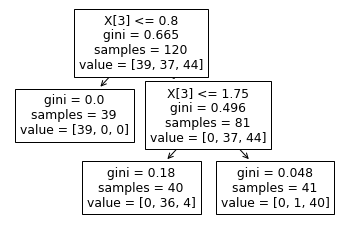

In [16]:
dtc = DecisionTreeClassifier(max_depth=2, criterion='gini', random_state=1)

dtc.fit(X_train, y_train)

plt.figure()
tree.plot_tree(dtc)
plt.show()

Of course, the plot is much nicer than our crude print method of our Decision Tree implementation. However, you should see the same core values at each node: (feature + threshold, Gini score, and number of samples). Again, the plot might not 100% match your Decision Tree as there are at least 2 ways to split the root node. But for all alternatives the root node should have a Gini score of **0.655**.

Predicting the labels of the test data:

In [17]:
y_pred = dtc.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')

print('The f1 score of your Decision Tree implementation on the IRIS dataset is {:.3f}'.format(f1))

The f1 score of your Decision Tree implementation on the IRIS dataset is 0.957


Again, this result should more or less match the one of your Decision Tree implementation, given the same parameter values for `max_depth` and `min_samples_split`.

---------------------------------------------------------

## 2 Evaluation with K-Fold Cross Validation

Basically all classification and regression models feature a set of hyperparameters that are not learned but affect the results. The evaluation of such models typically requires the repeated training and evaluation of the models with different values for those hyperparameters. Secondly, many different types of models can be applied for the same classification or regression task. Thus, most evaluation try to find (a) the best type of model and (b) the best set of hyperparameter values.

In the lecture, we discussed one of the most common approaches: k-fold cross validation. In this part, your task is to implement k-fold cross validation, use it to evaluate a set of classifiers with different hyperparameter values, and compare and discuss the results.

#### Load Dataset from File

We use a [Heart Disease dataset](https://www.kaggle.com/c/tech-weekend-data-science-hackathon/overview) for this task. Note that we only use a random sample of 10% of the whole dataset just avoid overly long runtimes. After all, k-fold cross validation requires to k runs for each choice of model and hyperparameter setting.

In [4]:
df = pd.read_csv('data/heart-disease-sample10p.csv')

## Sample dataset to reduce size
#sample_size = 0.01  # Just for Task 2.4 (see below)
#sample_size = 0.1  # Use 1%-10% for testing and debugging your code
sample_size = 1.0  # Use whole dataset to answer follow-up questions
df = df.sample(frac=sample_size, random_state=0)

df.head()

,ID,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal,class
3048,232357,57.294372,0,4.0,123.275300,261.044898,0,0,139.668164,0,3.506288,2,0,7,1
19563,81758,56.386738,0,4.0,139.014278,194.656534,0,2,119.645151,1,0.000000,2,2,7,1
58303,456561,42.346586,1,4.0,138.704557,214.488989,0,2,179.232328,0,0.305163,1,1,3,0
8870,389933,54.764206,1,4.0,128.729990,227.432627,1,2,99.487985,1,1.141893,2,1,7,1
40228,29811,60.037138,1,4.0,131.081960,269.109450,0,0,158.502502,1,1.755913,2,1,3,1


For your convenience, we split the dataframe into two, one containing the input features, the other containing the class labels. We also removed "ID" from the set of input features as such artificial attributes make very poor features in almost 100% of cases.

In [5]:
df_X = df.iloc[:,1:-1]
df_y = df.iloc[:,-1]

num_samples, num_features = df_X.shape
num_labels = df_y.nunique()

print('The dataset contains {} samples with {} features, and there a {} class labels'
      .format(num_samples, num_features, num_labels)
     )

The dataset contains 60000 samples with 13 features, and there a 2 class labels


### 2.1 Data Preprocessing

As usual, the first step is data preprocessing (informed by an EDA). Here, we can keep it simple and there's not much to do as this dataset does not contain any "dirty" records, particularly:
* There are no NA values in any of the columns/features
* There are no duplicate rows (even after removing "ID")

As such, there should be no need to remove any samples.

**Perform and data preprocessing/transformation steps you deem appropriate!** As it might affect your decision, the data will be used to train K-Nearest Neighbors (KNN) and tree-based models (recall: the tree-based classifiers of sklearn do not support categorical features!). Note that some preprocessing steps might be easier to perform on the pandas dataframe while others on the numpy arrays. This is why we provide 2 code cell, but it's up to which which one to use. We also imported `sklearn.preprocessing` for you to use.

In [6]:
#########################################################################################
### Your code starts here ###############################################################

# Convert Age to Integers
df_X['age']=df_X['age'].astype(int)

# Convert to object 
df_X['sex']=df_X['sex'].astype(object)
df_X['fasting_blood_sugar']=df_X['fasting_blood_sugar'].astype(object)
df_X['resting_electrocardiographic_results']=df_X['resting_electrocardiographic_results'].astype(object)
df_X['exercise_induced_angina']=df_X['exercise_induced_angina'].astype(object)
df_X['slope']=df_X['slope'].astype(object)
df_X['number_of_major_vessels']=df_X['number_of_major_vessels'].astype(object)
df_X['thal']=df_X['thal'].astype(object)


num_col = df_X.select_dtypes(include=np.number).columns

cat_col = df_X.select_dtypes(exclude=np.number).columns

#One hot encoding - Categorical data
cat_X = df_X.select_dtypes(exclude=np.number)

#dummy_X = pd.get_dummies(cat_X,drop_first=True)
dummy_X = pd.get_dummies(cat_X)

#Concat data
df_X = pd.concat([df_X.drop(list(cat_col), axis = 1),dummy_X],axis=1)

#Get numerical columns index
num_col_index = df_X.columns.get_indexer(num_col)
### Your code ends here #################################################################
#########################################################################################

In [7]:
# Convert dataframes to numpy arrays
X, y = df_X.to_numpy(), df_y.to_numpy()

# Split dataset in training and test data (20% test data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print('Number of features: {}'.format(X_train.shape[1]))
print('Number of samples for training: {}'.format(X_train.shape[0]))
print('Number of samples for testing: {}'.format(X_test.shape[0]))

Number of features: 25
Number of samples for training: 48000
Number of samples for testing: 12000


In [8]:
#########################################################################################
### Your code starts here ###############################################################

#num_X_train = X_train.select_dtypes(include=np.number)
#num_X_test = X_test.select_dtypes(include=np.number)


# Scale num data
# MinMaxScaler : rescale num variables into the range [0,1]
scaler = preprocessing.MinMaxScaler().fit(X_train[:, num_col_index]) 

X_train_transformed = scaler.transform(X_train[:, num_col_index])
X_test_transformed = scaler.transform(X_test[:, num_col_index])

X_train[:, num_col_index] = X_train_transformed
X_test[:, num_col_index] = X_test_transformed

### Your code ends here #################################################################
#########################################################################################

### 2.2 K-Fold Cross-Validation "By Hand" (5 Points)

The code below shows the basic loop for an evaluation using k-fold cross-validation. The only bits missing are the steps to (a) create the k folds and (b) to construct the training set of (k-1) folds and the validation set of 1 fold. For this task, use the `DecisionTreeClassifier` as it is the fastest to evaluate. The code below already contains commented lines for tasks 2.3 and 2.4.

**Implement k-fold cross-validation by completing the code below!** For testing and debugging, feel free to use a sample size of only 10% of the data reduce `num_folds` (e.g., 5) and `param_choices` (e.g., `[1, 2, 3]`) in the beginning. (Hint: Have a look at [`np.split`](https://numpy.org/doc/stable/reference/generated/numpy.split.html))

In [9]:
%%time

# num_folds = 10 # For testing debugging
num_folds = 10

# param_choices = [1, 3, 5] # For testing debugging
param_choices = [1, 2, 3, 5, 8, 10, 12, 15, 20, 25, 50]



X_train_folds = []
y_train_folds = []

#########################################################################################
### Your code starts here ###############################################################
X_fold_size = int(len(X_train) / num_folds)

indexes = np.array(range(len(X_train)))
np.random.shuffle(indexes) #shuffle indexes randomly
ind_splits = np.split(indexes, num_folds)

for i in range(num_folds):
    X_train_folds.append(X_train[ind_splits[i]])
    y_train_folds.append(y_train[ind_splits[i]])


### Your code ends here #################################################################
#########################################################################################


param_to_scores = {}


for param in param_choices:
    
    ## We want to keep track of the training score and validation score
    f1_train, f1_valid = [], []
    
    for i in range(num_folds):
        X_train_fold, X_valid_fold = None, None
        y_train_fold, y_valid_fold = None, None

        #########################################################################################
        ### Your code starts here ###############################################################
        
        # ith fold as valid fold; others as train fold
        
        X_valid_fold = X_train_folds[i] # 1 fold
        y_valid_fold = y_train_folds[i]
        # combining k-1 folds
       
        X_train_fold = np.array([fold for ind,sublist in enumerate(X_train_folds) for fold in sublist if ind != i]) 
        y_train_fold = np.array([fold for ind,sublist in enumerate(y_train_folds) for fold in sublist if ind != i])
        
        ### Your code ends here #################################################################
        #########################################################################################           

        ## For task 2.3: Train all the classifiers one-by-one and discuss the results
        classifier = DecisionTreeClassifier(max_depth=param).fit(X_train_fold, y_train_fold)
        #classifier = RandomForestClassifier(max_depth=param).fit(X_train_fold, y_train_fold)
        #classifier = GradientBoostingClassifier(max_depth=param).fit(X_train_fold, y_train_fold)
        #classifier = KNeighborsClassifier(n_neighbors=param).fit(X_train_fold, y_train_fold)
        
        ## For task 2.4 Run your own implementation of a Decision Tree!
        ## (Note: use use only 1% of the original dataset (sample_size=0.01)
        #classifier = MyDecisionTree(max_depth=param).fit(X_train_fold, y_train_fold)
        
        ## Predict labels for for training validation set
        y_pred_fold_train = classifier.predict(X_train_fold)
        y_pred_fold_valid = classifier.predict(X_valid_fold)
        
    
        ## Keep track of training and validation scores
        f1_train.append(f1_score(y_train_fold, y_pred_fold_train))
        f1_valid.append(f1_score(y_valid_fold, y_pred_fold_valid))
        
    ## Keep track of all num_folds f1 scores for current param (for plotting)
    param_to_scores[param] = (f1_train, f1_valid)
    
    ## Print statement for some immediate feedback
    print('param = {}, f1 (training) = {:.3f}, f1 (validation) = {:.3f}'.format(param, np.mean(f1_train), np.mean(f1_valid)))

param = 1, f1 (training) = 0.734, f1 (validation) = 0.734
param = 2, f1 (training) = 0.680, f1 (validation) = 0.680
param = 3, f1 (training) = 0.819, f1 (validation) = 0.819
param = 5, f1 (training) = 0.850, f1 (validation) = 0.847
param = 8, f1 (training) = 0.884, f1 (validation) = 0.868
param = 10, f1 (training) = 0.909, f1 (validation) = 0.862
param = 12, f1 (training) = 0.940, f1 (validation) = 0.850
param = 15, f1 (training) = 0.978, f1 (validation) = 0.834
param = 20, f1 (training) = 0.998, f1 (validation) = 0.826
param = 25, f1 (training) = 1.000, f1 (validation) = 0.825
param = 50, f1 (training) = 1.000, f1 (validation) = 0.825
CPU times: user 18.6 s, sys: 219 ms, total: 18.8 s
Wall time: 18.8 s


Using the `DecisionTreeClassifier` and the complete dataset (`sample_size=1.0`), the f1 score for the training data should reach 1.0. The best f1 score for the validation data should larger than 0.86 (again, this might slightly vary depending on how you have generated the folds and the training/validation data pairs, as well as on the preprocessing steps you have performed).

#### Visualization of Results

We provide you with 2 methods to visualize the results. `plot_validation_results()` shows all `num_folds` scores for each parameter setting together with the means and standard deviations of the validation scores.

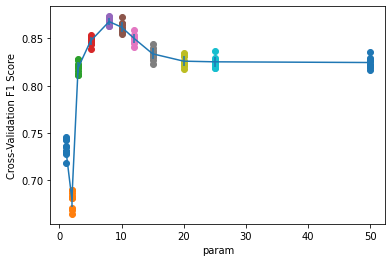

In [11]:
plot_validation_results(param_to_scores)

The method `plot_scores()` shows the training and validation scores for each parameter setting.

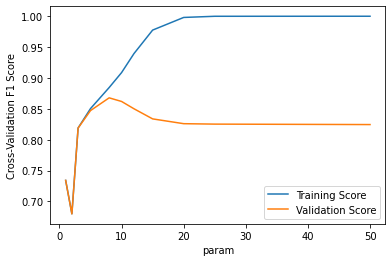

In [12]:
plot_scores(param_to_scores)

### 2.3 Evaluation of Different Classifiers (8 Points)

The code above for the k-fold cross-validation already contains the lines for the training of 4 different classifiers:

* [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) with `max_depth` as hyperparameter

* [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) with `max_depth` as hyperparameter

* [`GradientBoostingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) with `max_depth` as hyperparameter

* [`KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) with `n_neighbbors` as hyperparameter


**Run the k-fold cross validation for all 4 classifiers and compare and discuss the results.** You should see quite a number of differences regarding runtimes, issues of overfitting and underfitting, overall performance, etc. Some hints:

* Start with a sample size of 10% (`sample_size = 0.1`) of the dataset to see if everything is working; to solve this task, please use the whole data (`sample size =1.0`)
* Use the methods `plot_scores()` and `plot_validation_results` to visualize the results; save the 2 plots for each classifiers as images so you can easily compare them side by side (there's no need to submit the images later!)

**Your answer:**

Differences

(1) Runtimes

DecisionTreeClassifier runtime is 18.8s (Wall time), which is not expensive to train and test. 

RandomForestClassifier runtime is slower as 4min 56s, might because it has more trees that needed to be processed. 

GradientBoostingClassifier runtime is long: 47min 22s. While bagging(random forest) trees are trees can be trained in parallel, Boosting trees are trained in sequence which takes longer time.

KNeighborsClassifier runtime is slowest: 1h 2min 48s(Wall time). As the feature dimension is high and computing distances between features is very expensive in this case.

(2) Overfitting and underfitting

DecisionTreeClassifier is more possible to overfit with a large tree. In this case, when max_depth>10, it's overfitting and the F1 score and validation score start to decrease.

Random Forest also receives best F1 score when the max_depth is about 12. It is less likely to overfit as more trees result in a more robust model. But still the validation score stops to increase when max_depth is about 10 while the training score keeps to increase until max_depth reaches 20.

Compared to decision tree and random forest, GradientBoostingClassifier appears to be easier to overfit and it's more sensitive to noise data. It also tend to be harder to tune than random forest. The training F1 score reaches 100 when max_depth = 12 while validation F1 score starts to decrease when max_depth >= 5.

KNeighborsClassifier: When the k is too small (1 or 2 in this case), predictions are sensitive to outliers and tend to overfitting. When the k is large, the regression line becomes smooth and it tends to underfitting.(The training score decreases while the validation score increases.)



(3) Overall Performance

Gradient boosting seems to have overall best performance with best accuracy and score. It's best F1 training score is 1 and best F1 validation score is 0.887. It can perform better compared to other classifiers with good hyperparameter(in this case max_depth) setting.

Decision tree and Random Forest also reach best F1 training score as 1. The best F1 validation score of decision tree is 0.869. And the best F1 validation score of random forest is 0.882, slightly lower than gradient boosting. Random Forest uses feature sampling results into lower variance and higher accuracy.

KNN's best F1 training score is 1 when k = 1(overfitting), and best F1 validation score is 0.867 when k = 15(F1 training score: 0.879). KNN requires that the distance can be meaningfully calculated, and that might affect performance. And in this case there are many features, so we can see from the diagram the prediction scores converge. Distances between some of the features cannot be meaningfully calculated which might influence the performance.

(4) Interpretability

Decision Tree and KNN is very intuitive and easy to read/interpret, while Gradient Boosting and Random Forest is complicated to interpret (Gradient Boosting even less than random forest).

--------------------------------------------

### 2.4 Towards Improving `MyDecisionTree` (8 Points)

While your Decision Tree works alright on the IRIS dataset, it's only a basic implementation and naturally has its limitations. This part looks into two of these limitations, as well as potential solutions to address them. (**Note:** There will be no need need for any implementation!)

**2.4 a) (4 Points)** The code above for the k-fold cross validation already contains the line for training your `MyDecisionTree` classifier. When you run it on even a small sample size of 1% (`sample_size = 0.01`) of the dataset, you will notice the very poor runtimes (compared to scikit-learn's [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html))

**Identify the cause(s) of the poor runtime in the code of `MyDecisionTree` and propose suitable optimizations!** You can speculate as long as you can make good arguments. Your solutions may include heuristics that do not necessarily guarantee the same results as the current implementation.

**Your answer:**

The runtime for myDecisionTree is 49.9s (sample_size = 0.01), much longer than DecisionTreeClassifier (only 188 ms).

Possible causes:
- DecisionTreeClassifier might have different early stopping criteria and pruning strategies which improve tree's simplicity and speed
- DecisionTreeClassifier might restrict nodes size of whole tree besides max_depth
- There are too many features when considering best split. myDecisionTree will consider them all which might slow down the process
- When making prediction, DecisionTreeClassifier might use search strategies such as build depth-first tree to improve efficiency 

Propose optimizations:
- 1. Instead of stop splitting when gini impurity of spliting decreases compared to orginal node's gini score, we can set a threshold for minimum decrease of impurity. This way, a node will only split if the impurity decrease is greater than this threshold. 
- 2. We can also set a threshold for minimum impurity to split. A node will only split if its impurity is above the threshold (early stopping), otherwise it's a leaf.
- 3. Define pre-sorting strategy when finding spliting. As we set maximum depth of the tree, sorting data in advance might sometimes help speed up the process of finding the optimal spliting (depending on the size of tree)
- 4. Set a max_feature_num value to restrict the nums of features to consider when finding best split. For example, if not specified by user, we only consider sqrt(nums_of_feature) features (choosing randomly) when looking for a best split.
- 5. Restrict minimum samples to consider as a leaf. When we find a split, its leaf node must have at least minimum_samples_num at each of left and right branches.
- 6. If we set restriction threshold of max_depth or max_leaf_nodes of a tree, we can use best first to build a tree to improve searching efficiency; otherwise we can use depth first strategy as DFS is usually faster in this case


**2.4 b) (4 Points)** `MyDecisionTree` only supports numerical features. However, we saw in the lecture that Decision Trees in general work perfectly fine with categorical features; the slides included examples of splitting and scoring nominal and ordinal features. The problem is that the methods for splitting depend on the type of a feature, and the Decision Tree classifier does not *know* which type each feature is. A "manual" solution would be to explicitly specify the type of each features, for example like

`classifier.fit(X_train, y_train, feature_types=[RATIO, RATIO, NOMINAL, RATIO, ORDINAL, INTERVAL])`

assuming that `X_train` has 6 features; see Lecture 1 for the 4 different feature types. However, such manual specification can be very tedious particularly when the feature set frequently changes during extensive evaluations.

**Propose an algorithm (in pseudo code) to automatically identify the type of a feature!** Your algorithm won't be foolproof and 100% correct in all cases -- if such a perfect algorithm for this task would exist it would already be commonplace. However, try to identify meaningful rules or heuristics to identify the the type of a feature, but also discuss any cases that can NOT be solved, at least in practice. (Hint: Approach this problem as if you were given a dataset without any documentation and even without the names of features -- that is, you only know the data type and values of the features.)

**Your answer:**